In [1]:
import keras
import csv
import os
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.densenet import DenseNet121
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
TRAIN_DIR = os.path.join(ROOT_DIR, 'data', 'train')
TEST_DIR =  os.path.join(ROOT_DIR, 'data', 'validation')

In [4]:
img_width, img_height = 300, 300

In [5]:
batch_size = 32
epoch = 10
drop_prob = 0.7
out_class = 13

In [6]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [7]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 152397 images belonging to 13 classes.


In [9]:
'''val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')'''

"val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), \n                                                batch_size=batch_size, class_mode='categorical')"

In [10]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 55388 images belonging to 13 classes.


In [11]:
input_ = Input(shape=(img_width, img_height, 3))

transfer_model = DenseNet121(input_tensor = input_, weights = 'imagenet', include_top = False)

29089792/29084464 [==============================] - 5s 0us/step


In [12]:
x = transfer_model.output

x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

In [13]:
model = Model(inputs = transfer_model.input, outputs = out)

In [14]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [15]:
for layer in transfer_model.layers:
    layer.trainable = False

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [ ]:
#tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

In [ ]:
checkpointer = ModelCheckpoint(filepath='checkpoint_inception.h5', save_best_only=True)

In [ ]:
callback_list = [checkpointer]

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch = int(152397/batch_size), epochs = epoch, shuffle = True)

Epoch 1/10
4762/4762 [==============================] - 2041s 429ms/step - loss: 1.1879 - acc: 0.7676
Epoch 2/10
4762/4762 [==============================] - 1993s 419ms/step - loss: 0.5759 - acc: 0.8646
Epoch 3/10
4762/4762 [==============================] - 1990s 418ms/step - loss: 0.5070 - acc: 0.8767
Epoch 4/10
4762/4762 [==============================] - 2092s 439ms/step - loss: 0.4894 - acc: 0.8811
Epoch 5/10
4762/4762 [==============================] - 2094s 440ms/step - loss: 0.4774 - acc: 0.8843
Epoch 6/10
4762/4762 [==============================] - 2044s 429ms/step - loss: 0.4772 - acc: 0.8853
Epoch 7/10
4762/4762 [==============================] - 2044s 429ms/step - loss: 0.4743 - acc: 0.8861
Epoch 8/10
4762/4762 [==============================] - 2032s 427ms/step - loss: 0.4741 - acc: 0.8876
Epoch 9/10
4762/4762 [==============================] - 2050s 430ms/step - loss: 0.4745 - acc: 0.8890
Epoch 10/10
4762/4762 [==============================] - 2053s 431ms/step - loss: 

In [19]:
Y_pred = model.predict_generator(test_generator, int(55388/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [20]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(55388/batch_size+1))

In [21]:
test_loss

5.070682664481261

In [22]:
test_accuracy

0.36325557883004295

In [ ]:
model_check = load_model('checkpoint_inception.h5')

In [ ]:
#test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [ ]:
test_check_loss

In [ ]:
test_check_acc

In [23]:
target_names = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 
                'skateboard', 'train', 'truck']

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [25]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[ 321  117 1027  295   95  115  287   30   38  247  981   93]
 [ 334   96 1018  262   78   98  256   34   30  212  986   71]
 [ 445  149 1380  338  106  127  367   32   48  294 1291  113]
 [ 914  273 3083  804  229  259  834   93  104  726 2820  262]
 [ 426  107 1380  363  123  131  356   35   44  309 1304  113]
 [ 206   56  576  155   51   47  150   19   19  158  595   43]
 [ 551  148 1734  425  126  140  430   52   59  398 1590  143]
 [ 349  115 1150  299   90  102  309   39   45  280 1131   91]
 [ 385  119 1339  367   90   97  365   47   39  287 1294  120]
 [ 214   57  679  178   53   51  150   22   27  165  626   59]
 [ 395  115 1197  377  109  114  345   45   30  268 1122  119]
 [ 509  162 1652  447  115  151  451   52   44  344 1485  136]]


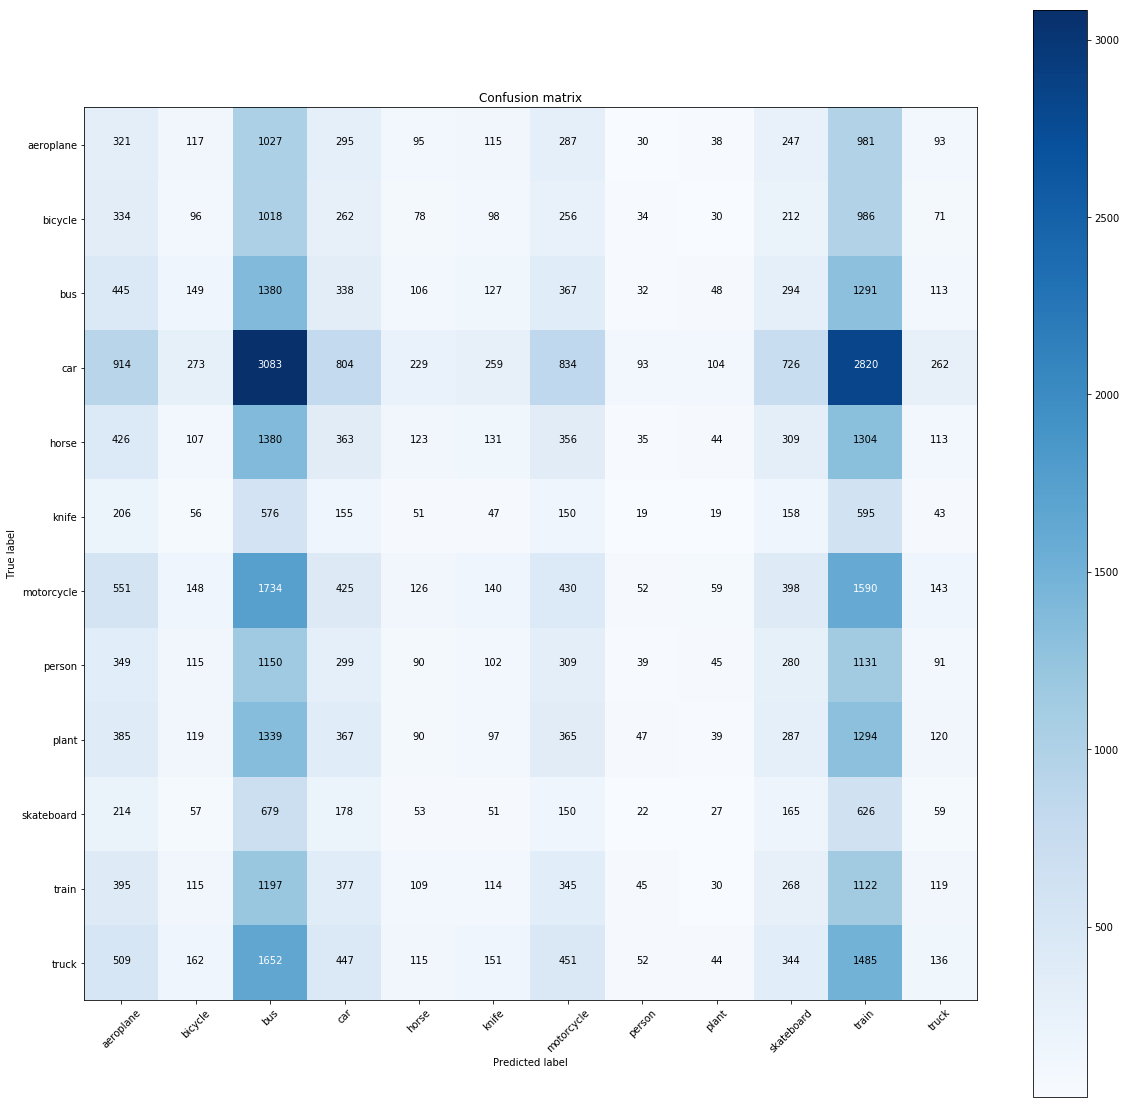

In [26]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [27]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aeroplane       0.06      0.09      0.07      3646
     bicycle       0.06      0.03      0.04      3475
         bus       0.09      0.29      0.13      4690
         car       0.19      0.08      0.11     10401
       horse       0.10      0.03      0.04      4691
       knife       0.03      0.02      0.03      2075
  motorcycle       0.10      0.07      0.09      5796
      person       0.08      0.01      0.02      4000
       plant       0.07      0.01      0.02      4549
  skateboard       0.04      0.07      0.06      2281
       train       0.07      0.26      0.12      4236
       truck       0.10      0.02      0.04      5548

   micro avg       0.08      0.08      0.08     55388
   macro avg       0.08      0.08      0.06     55388
weighted avg       0.10      0.08      0.07     55388



In [28]:
model.save('densenet.h5')